In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from DataFields import DataFields
from DataFields import DateReportedFields
from ProjectFunctions import get_columns_from_chunk
from ProjectFunctions import convert_date_to_binary
from ProjectFunctions import count_na_in_dataframe
from ProjectFunctions import count_na_and_negative
from ProjectFunctions import one_hot_encode_vascular_problems
from ProjectFunctions import drop_rows_with_na_greater_than
from ProjectFunctions import map_education_levels, map_vascular_levels


In [3]:
diagnosed_df = pd.read_csv("diagnosed.csv")

# Some fields report diagnosis by assigning the diagnosis date, while NA implies undiagnosed.
# convert features specified in "DateRportedFields" from date values, to binary
# meaning: NA = 0, Any date in range (see function) as 1
#diagnosed_df = convert_date_to_binary(diagnosed_df, DateReportedFields)

# Count number of NA values per feature.
count_na_in_dataframe(diagnosed_df, exclude=DateReportedFields)

Lipoprotein A: 612 NA rows
Direct bilirubin: 458 NA rows
Testosterone: 401 NA rows
SHBG: 370 NA rows
Apolipoprotein A: 366 NA rows
Calcium: 356 NA rows
Glucose: 355 NA rows
Phosphate: 354 NA rows
Total protein: 353 NA rows
HDL cholesterol: 353 NA rows
Albumin: 353 NA rows
Vitamin D: 302 NA rows
Apolipoprotein B: 212 NA rows
C-reactive protein: 209 NA rows
IGF-1: 209 NA rows
Urate: 207 NA rows
Total bilirubin: 206 NA rows
Aspartate aminotransferase: 205 NA rows
LDL direct: 204 NA rows
Pulse Rate at Blood Pressure: 203 NA rows
Blood Pressure Diastolic: 203 NA rows
Blood Pressure Systolic: 203 NA rows
Urea: 201 NA rows
Cholesterol: 201 NA rows
Triglycerides: 200 NA rows
Gamma glutamyltransferase: 200 NA rows
Creatinine: 200 NA rows
Alanine aminotransferase: 199 NA rows
Alkaline phosphatase: 199 NA rows
Cystatin C: 199 NA rows
High light scatter reticulocyte percentage: 179 NA rows
Immature reticulocyte fraction: 179 NA rows
Mean sphered cell volume: 179 NA rows
Mean reticulocyte volume: 1

#### The following fields were removed due to significant count of NA values:
* Oestradiol
* Rheumatoid factor
* Recent trouble concentrating on things
* Bipolar or Major Depression
* Ever had prolonged feelings of sadness or depression

#### Map education and vascular problems

In [4]:

# map education in increasing hierarchy
diagnosed_df = map_education_levels(diagnosed_df)

# map vascular problems to meaningful values
diagnosed_df["Report of vascular problems"] = diagnosed_df["Report of vascular problems"].replace({-7: 0, -3: pd.NA})

diagnosed_df.to_csv("diagnosed_processed.csv", index=False)

#### Histogram of patients by NA values

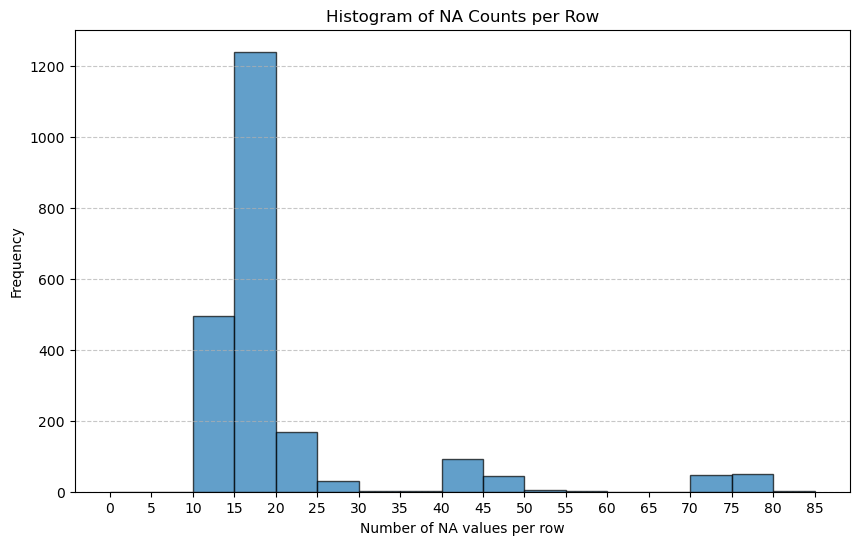

In [5]:

# plot a histogram out of patients to see how many patients miss a lot of data, and which not much.
def plot_na_histogram(df):
    na_counts = df.isna().sum(axis=1)  # Count NA values per row
    bin_size = 5
    max_na = na_counts.max()
    bins = list(range(0, max_na + bin_size, bin_size))
    plt.figure(figsize=(10, 6))
    plt.hist(na_counts, bins=bins, edgecolor='black', alpha=0.7)
    plt.xlabel('Number of NA values per row')
    plt.ylabel('Frequency')
    plt.title('Histogram of NA Counts per Row')
    plt.xticks(bins)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


df = pd.read_csv("diagnosed_processed.csv")

plot_na_histogram(df)

#### Remove patients with too many NA values

In [6]:

df = pd.read_csv("diagnosed_processed.csv")
df = df.drop(columns=["id"])
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].mask(df[numeric_cols] < 0)
df = drop_rows_with_na_greater_than(df, 45)
df.describe()


,Birth Year,Sex,Education,BMI Impedance,Smoking Status,Ever Smoked,Alcohol Intake Frequency,Report of stroke,Diabetes Diagnosed By Doctor,Report of vascular problems,...,Platelet crit,Platelet distribution width,Red blood cell (erythrocyte) count,Red blood cell (erythrocyte) distribution width,Reticulocyte count,Reticulocyte percentage,White blood cell (leukocyte) count,Blood Pressure Diastolic,Blood Pressure Systolic,Pulse Rate at Blood Pressure
count,2036.000000,2036.000000,1987.000000,2023.000000,2015.000000,2015.000000,2030.000000,636.000000,2026.000000,2020.000000,...,2028.000000,2028.000000,2028.000000,2028.000000,2000.000000,2000.000000,2028.000000,1882.000000,1882.000000,1882.000000
mean,1943.149804,0.592338,1.187217,28.530256,0.697270,0.670471,3.196552,9.050314,0.218164,1.927723,...,0.228862,16.542875,4.489971,13.726065,0.064325,1.435798,7.337988,81.928799,147.266738,70.897450
std,4.261554,0.491520,1.130542,5.071778,0.677828,0.470159,1.704165,6.126795,0.413101,1.768057,...,0.052135,0.532506,0.444221,1.095836,0.035353,0.805229,1.957395,11.217687,21.106375,13.242859
min,1937.000000,0.000000,0.000000,15.757600,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.064000,15.200000,1.720000,11.490000,0.012000,0.263000,2.370000,47.000000,78.000000,35.000000
25%,1940.000000,0.000000,0.000000,25.079600,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,...,0.195000,16.200000,4.200000,13.100000,0.045000,1.020000,6.027500,74.000000,133.000000,62.000000
50%,1942.000000,1.000000,1.000000,27.787800,1.000000,1.000000,3.000000,11.000000,0.000000,2.000000,...,0.224000,16.500000,4.485000,13.530000,0.060000,1.330000,7.120000,82.000000,146.000000,69.500000
75%,1945.000000,1.000000,2.000000,31.366050,1.000000,1.000000,5.000000,11.000000,0.000000,4.000000,...,0.257250,16.860000,4.773250,14.100000,0.078000,1.740000,8.410000,89.000000,160.000000,79.000000
max,1968.000000,1.000000,3.000000,54.528300,2.000000,1.000000,6.000000,22.000000,1.000000,4.000000,...,0.624000,19.400000,6.390000,31.700000,1.077000,25.278000,34.130000,132.000000,241.000000,169.000000


In [8]:
df.to_csv("diagnosed_processed.csv", index=False)

#### Estimate new values for missing columns using Iterative Imputer (Optinal for some xgb)

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
import time

In [ ]:
df = pd.read_csv("diagnosed_processed.csv")

imputer = IterativeImputer(max_iter=50)
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

df_imputed.to_csv("diagnosed_imputed.csv", index=False)
df_imputed.describe()